In [1]:
import json
import pymysql
import datetime
import feedparser
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pprint as pprint
import matplotlib.pyplot as plt 

import newsite_db_class as db_conn

from os import path
from PIL import Image
from bs4 import BeautifulSoup  
from html.parser import HTMLParser
from wordcloud import WordCloud, STOPWORDS

# encoding: utf-8
%matplotlib inline

f = '%Y-%m-%d %H:%M:%S'
#now = datetime.datetime.now()
#now.strftime(f) 

import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re

# load the names, url, rss feeds of news sites
with open('contraction_for_NLTK.json', 'r') as fp:
    contractions = json.load(fp)

In [2]:
# establish connection
DB_instance = db_conn.databaseInterface()
    
def preprocess(text):
    
    text = text.replace("VIDEO","")
    text = text.replace("‘","'")
    text = text.replace("PHOTOS","")
    
    # get rid of common contractions
    for words in text.split():
        if words in contractions.keys():
            text = text.replace(words,contractions[words].split("/")[0])
            #print(words)
    stopWords = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    wordsFiltered = []

    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    for i,word in enumerate(wordsFiltered):
        if "'s" in word:
            wordsFiltered[i] = word.split("'s")[0]
            
    #new_list = [word for word in wordsFiltered if word not "\'s"]
    
    return " ".join(wordsFiltered)

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    #parser = HTMLParser()
    #html = parser.unescape(html)
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [3]:
# remind what the mapping is between names and source_id's
sql_query = "SELECT source_id, name_of_site FROM sources;"
results = DB_instance.read_table_given_sql(sql_query)

# df for mapping
site_id_mapping_df = pd.DataFrame(columns=['name_of_site','source_id'])
site_id_mapping_df['name_of_site'] = [row['name_of_site'] for row in results['results']]
site_id_mapping_df['source_id'] = [row['source_id'] for row in results['results']]


# Test NLTK 
* make lists of positive and negative words to score with

In [4]:
# Make a dictionary of positive and negative words; 
# from http://www.wjh.harvard.edu/~inquirer/homecat.htm
pos_neg_words = pd.read_csv('inquirerbasic.csv')
pos_words = pos_neg_words[pos_neg_words['Positiv'] == 'Positiv']['Entry'].reset_index(drop=True)
neg_words = pos_neg_words[pos_neg_words['Negativ'] == 'Negativ']['Entry'].reset_index(drop=True)
pos_words = [word.lower() for word in pos_words]
neg_words = [word.lower() for word in neg_words]

In [5]:
# gather data from database
sql_query = "SELECT summary FROM source_data WHERE source_id = '17' AND date = '2017-06-17 13:27:00';"
sql_query = "SELECT summary FROM source_data WHERE source_id = '19';"
results = DB_instance.read_table_given_sql(sql_query)

# Must preprocess the data. Take out all HTML tags, contractions and make all lowercase (see preprocess method)
summaries = ""
for row in results['results']:
    summary_raw = row['summary']
    summary_no_HTML = cleanhtml(summary_raw)
    summary = preprocess(summary_no_HTML)
    summaries += " "+summary

In [6]:
def report_scores_text(text):
    # tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    text_nltk = nltk.Text(tokens)
    one_grams = nltk.FreqDist(text_nltk)
    #text_nltk.collocations()
    
    positive_score,negative_score = 0,0
    positive_list = []; negative_list = [];

    for word in one_grams.most_common():
        # does the word appear in pos_neg?
        if word[0] in pos_words:
             positive_list.append(word[0]) 
        if word[0] in neg_words:
             negative_list.append(word[0])

    # Compute the positive score, the negative score for each news articles
    positive_score = len(positive_list) ; negative_score = len(negative_list);
    #print(positive_list) ; print(negative_list) ;
    print("Positive socre: ",positive_score) ; print("Negative score: ",negative_score);
    print("Neutral score: ",len(one_grams) - (positive_score + positive_score))

In [7]:
report_scores_text(summaries)

Positive socre:  190
Negative score:  197
Neutral score:  3905


In [8]:
df_happiness = _load_happy_text()

NameError: name '_load_happy_text' is not defined

# Happiness index

In [34]:
import sentiment_analysis_web_news as sent
# establish connection
DB_instance = db_conn.databaseInterface()
site_list = DB_instance.return_source_name_id()

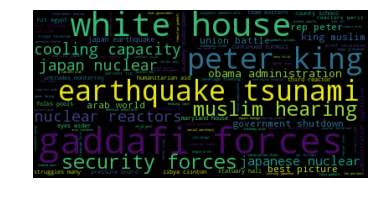

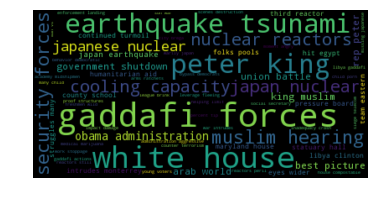

Happiness of  washingtonpost  is  5.196518072289161
Positive socre:  24
Negative score:  29
Neutral score:  607


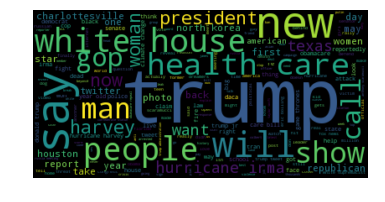

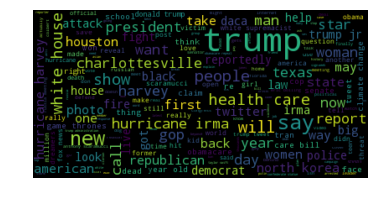

Happiness of  huffingtonpost  is  5.329319908356456
Positive socre:  202
Negative score:  233
Neutral score:  5456


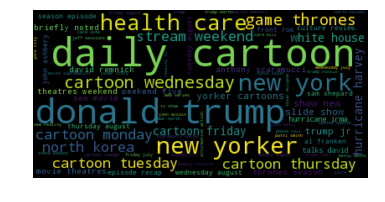

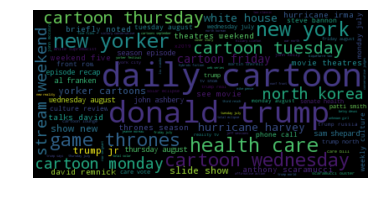

Happiness of  newyorker  is  5.417356360105426
Positive socre:  148
Negative score:  164
Neutral score:  3416


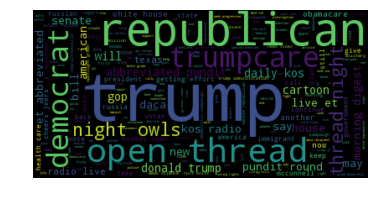

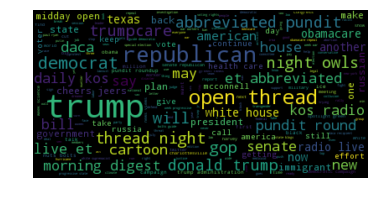

Happiness of  dailykos  is  5.324369271671427
Positive socre:  124
Negative score:  191
Neutral score:  3594


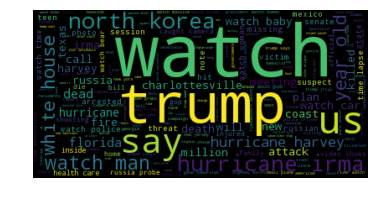

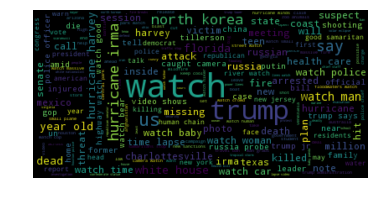

Happiness of  abcnews  is  5.298532915946369
Positive socre:  112
Negative score:  171
Neutral score:  4066


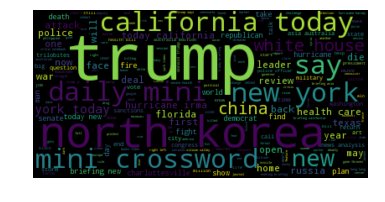

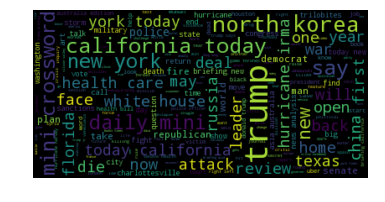

Happiness of  nytimes  is  5.320904228077169
Positive socre:  227
Negative score:  313
Neutral score:  6648


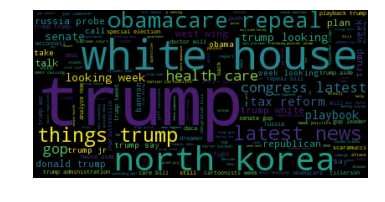

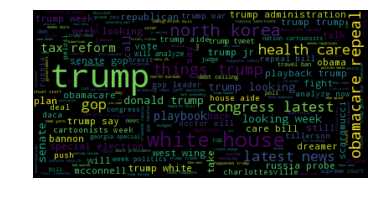

Happiness of  politico  is  5.281624635788203
Positive socre:  151
Negative score:  232
Neutral score:  4270


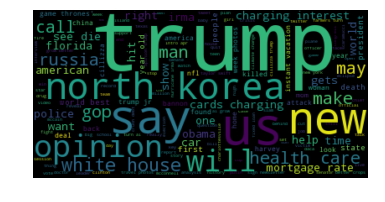

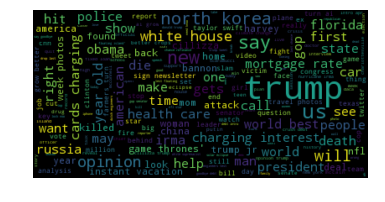

Happiness of  cnn  is  5.392051515703786
Positive socre:  225
Negative score:  344
Neutral score:  6933


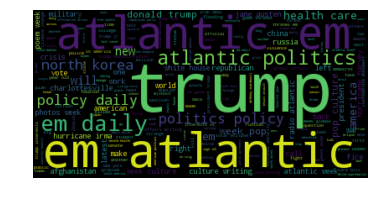

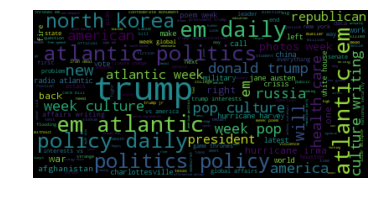

Happiness of  theatlantic  is  5.308888196823421
Positive socre:  150
Negative score:  199
Neutral score:  3523


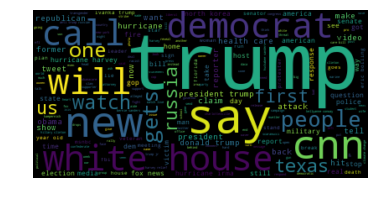

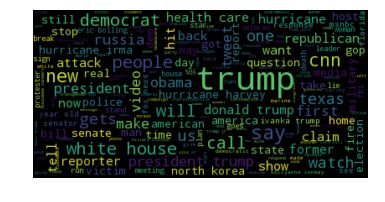

Happiness of  ijr  is  5.318085607424834
Positive socre:  131
Negative score:  190
Neutral score:  3913


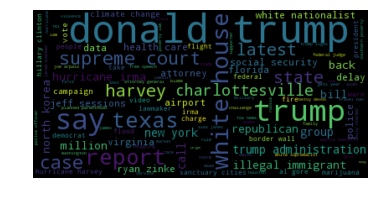

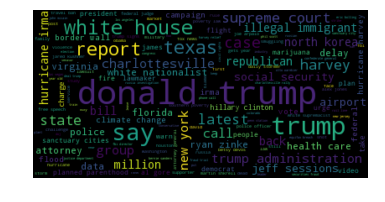

Happiness of  washingtontimes  is  5.227093437592808
Positive socre:  116
Negative score:  183
Neutral score:  4064


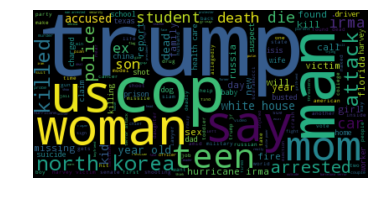

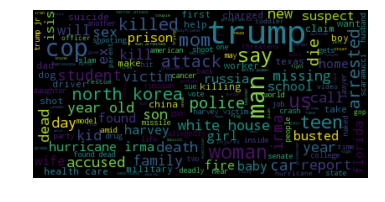

Happiness of  nypost  is  5.1897366896624355
Positive socre:  114
Negative score:  219
Neutral score:  4765


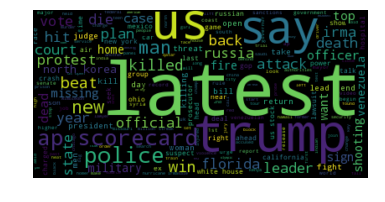

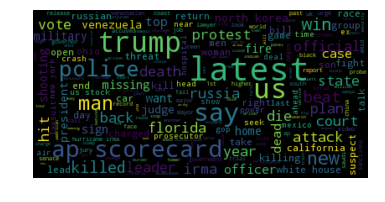

Happiness of  townhall  is  5.270215792646172
Positive socre:  95
Negative score:  122
Neutral score:  3683


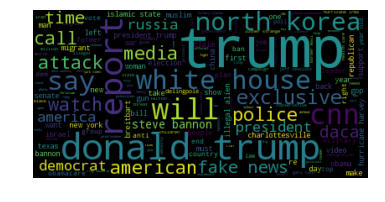

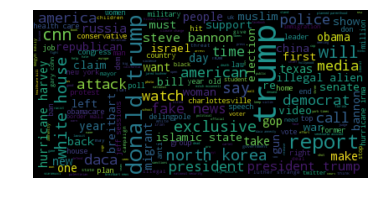

Happiness of  breitbart  is  5.283232630697782
Positive socre:  275
Negative score:  375
Neutral score:  8062


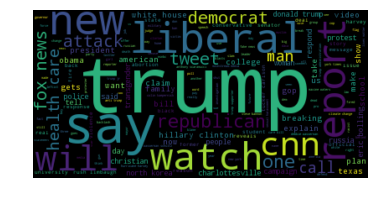

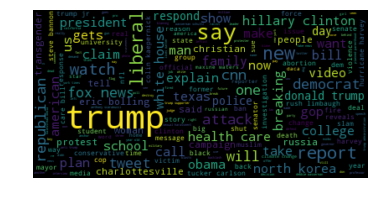

Happiness of  theblaze  is  5.289499203277961
Positive socre:  104
Negative score:  166
Neutral score:  3478


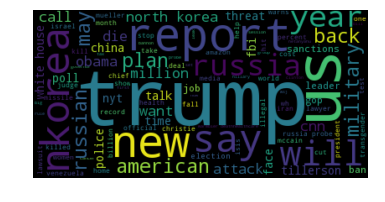

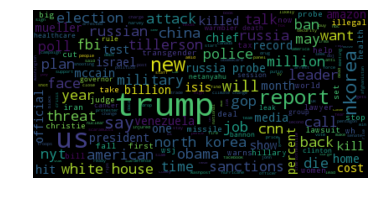

Happiness of  newsmax  is  5.270231532524803
Positive socre:  168
Negative score:  229
Neutral score:  4772


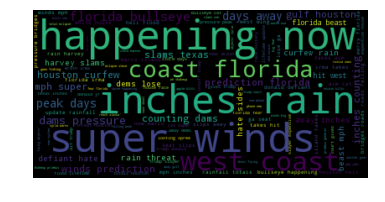

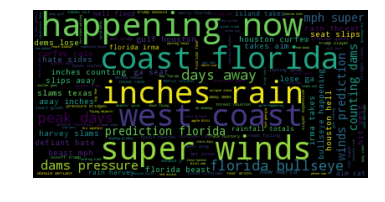

Happiness of  drudgereport  is  5.1851605143861565
Positive socre:  15
Negative score:  50
Neutral score:  867


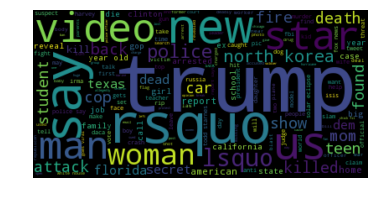

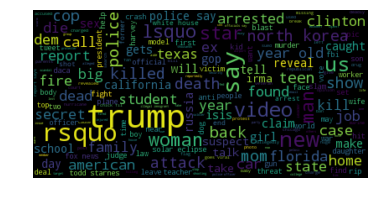

Happiness of  foxnews  is  5.271976445671028
Positive socre:  193
Negative score:  329
Neutral score:  7061


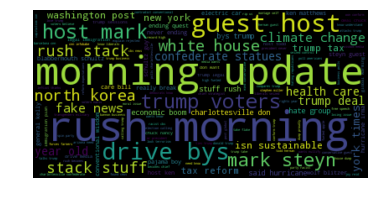

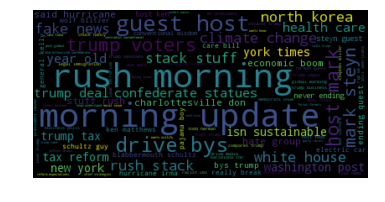

Happiness of  rushlimbaugh  is  5.301581039623216
Positive socre:  51
Negative score:  91
Neutral score:  1789


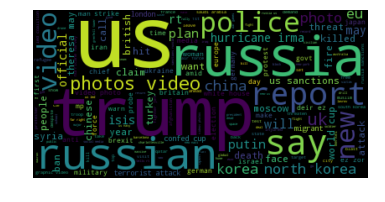

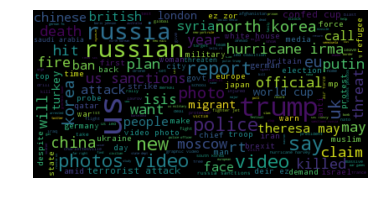

Happiness of  russia_today  is  5.268304170530106
Positive socre:  307
Negative score:  508
Neutral score:  9903


In [45]:
for site in site_list.values:
    # happiness scores for all sites (total summary)
    sql_query = "SELECT title FROM source_data WHERE source_id = '%s';" %site[1]
    results = DB_instance.read_table_given_sql(sql_query)

    # Must preprocess the data. Take out all HTML tags, contractions and make all lowercase (see preprocess method)
    summaries = ""
    for row in results['results']:
        summary_raw = row['title'].lower()
        #summary_no_HTML = cleanhtml(summary_raw)
        #summary = preprocess(summary_no_HTML)
        #print(summary_raw)
        summaries += " "+summary_raw
    text = summaries
    text = text.replace("(video)","")
    text = text.replace("‘","'")
    text = text.replace("(photo)","")
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    print("Happiness of ",str(site[0])," is ",sent.happiness_score(summaries))
    report_scores_text(summaries)

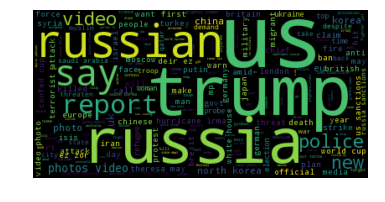

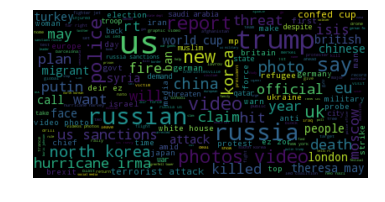

In [44]:
from wordcloud import WordCloud
text = summaries
text = text.replace("(video)","")
text = text.replace("‘","'")
text = text.replace("(photo)","")
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

" man who once survived niagara falls plunge dies after 2nd attempt cancelling brexit would be ‘great’ – german minister rescued polar bear 'with 6th sense’ joins hermitage cat in predicting confed & world cup results saudi official who killed german cyclist uses diplomatic immunity to avoid prosecution putin: new us sanctions harmful to relations, but russia will deal man awarded $870,000 after surgeon removes wrong testicle russia 2-0 new zealand – hosts victorious in confed cup curtain raiser in st. petersburg theresa may admits gov response to grenfell fire ‘not good enough’ russian airstrikes kill 2 isis commanders, thwart major attack on deir ez-zor – military 'witch hunt': trump tweets he is under fbi investigation ‘long-haul’ afghan war to turn into ‘generational struggle’ involving us troops – petraeus police detain protesters in berlin as anti-immigrant rally faces off with counter demo (videos) ‘race catastrophe’: twitter calls for #justiceforphilando after cop acquitted of 